### Домашнее задание

- Обучите нейронную сеть на датасете indoor-outdoor и оцените её качество (3 балла)
- Для обучения введите автоматическое разбиение на train/val в пропорции 70/30 (0.5 балла)
- Постройте графики метрик качества (1 балл)
- Попробуйте поменять гиперпараметры и сделать выводы о том, как это влияет на качество (0.5 балла).

### По желанию (*но всячески приветствуется*)
- Попробуйте вычислить F1-меру и построить confusion matrix
- При разбиение на train/val сравните результаты со стратификацией и без нее

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

**в колабе удобнее**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Dec 15 07:54 kaggle.json


In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                         title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset         Customer Shopping (Latest Trends) Dataset     76KB  2024-11-23 15:26:12          11805        233  1.0              
hopesb/student-depression-dataset                           Student Depression Dataset.                  454KB  2024-11-22 17:56:03           8302        110  0.9411765        
gauthamvijayaraj/spotify-tracks-dataset-updated-every-week  Spotify Tracks Dataset (Updated every week)    5MB  2024-12-09 18:00:01           1242         26  1.0              
ashutosh598/shoes-price-for-various-brands                  Shoes price for various brands                32KB  202

In [7]:
!kaggle datasets download -d aryanganotra/indooroutdoordataset

Dataset URL: https://www.kaggle.com/datasets/aryanganotra/indooroutdoordataset
License(s): unknown
 98% 1.33G/1.35G [00:18<00:00, 125MB/s]
100% 1.35G/1.35G [00:18<00:00, 76.5MB/s]


In [ ]:
!unzip indooroutdoordataset.zip

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18

import os
from PIL import Image
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [10]:
# создаём датасет
class IndoorOutdoorDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_paths = []
        self.labels = []

        for folder in ['train', 'test']:
            for subfolder in ['GT', 'dcp', 'hazy']:
                for file in os.listdir(os.path.join(root_dir, folder, subfolder)):
                    if file.endswith('.jpg'):
                        self.image_paths.append(os.path.join(root_dir, folder, subfolder, file))
                        self.labels.append(subfolder)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = Image.open(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        label = self.labels[index]
        if label == 'GT':
            label = torch.tensor(0)
        elif label == 'dcp':
            label = torch.tensor(1)
        elif label == 'hazy':
            label = torch.tensor(2)

        return image, label

In [11]:
resnet_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


dataset = IndoorOutdoorDataset(root_dir="/content", transforms=resnet_transforms)
print(f"{len(dataset) = }")

len(dataset) = 3000


In [12]:
from torch.utils.data import random_split


train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [13]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
def model_eval(model, dataloader, criterion, device, loss=False):
    correct = 0
    total = 0
    loss = 0
    for images, labels in dataloader:
        images = images.to(device)

        outputs = model(images)
        outputs = outputs.to('cpu').detach()

        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if not loss:
            loss += criterion(outputs, labels).item()

    accuracy = 100 * (correct / total)
    return accuracy, loss


def train(model, trainloader, testloader, epochs, criterion, optimizer, device, PATH):
    model = model.to(device)
    num_samples_train = len(trainloader)
    num_samples_test = len(testloader)

    train_loss_history = []
    train_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []

    # TRAINING
    try:
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0.0
            for inputs, labels in tqdm(trainloader):
                inputs = inputs.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                outputs = outputs.to('cpu')

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            train_loss_history.append(epoch_loss / num_samples_train)
            print(f"TRAINING SET\tEPOCH: {epoch + 1}\tTOTAL LOSS {(epoch_loss / num_samples_train):.5f}")

            # EVALUATING ON TRAIN SET
            accuracy_train, _ = model_eval(model, trainloader, criterion, device, loss=False)
            train_accuracy_history.append(accuracy_train)

            print(f"TRAINING SET\tEPOCH: {epoch + 1}\tTOTAL ACCURACY {accuracy_train:.5f}%")

            # EVALUATING ON TEST SET
            model.eval()
            with torch.no_grad():
                accuracy_test, loss_test = model_eval(model, testloader, criterion, device, loss=True)

            test_loss_history.append(loss_test / num_samples_test)
            test_accuracy_history.append(accuracy_test)

            print(f"TEST SET\tEPOCH: {epoch + 1}\tTOTAL LOSS {(loss_test / num_samples_test):.5f}")
            print(f"TEST SET\tEPOCH: {epoch + 1}\tTOTAL ACCURACY {accuracy_test:.5f}%")
            print()

            # IF ACCURACY ON TEST DECREASES
            if len(test_accuracy_history) > 3:
                last_three_acc_avg = sum(test_accuracy_history[-4:-1]) / 3
                if accuracy_test < last_three_acc_avg:
                    torch.save(model.state_dict(), PATH)
                    print("FINISHED\tACCURACY DECREASES")
                    return train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history

    except KeyboardInterrupt:
        torch.save(model.state_dict(), PATH)
        print("FINISED\tKEYBOARD INTERRUPT")
        return train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history

    torch.save(model.state_dict(), PATH)
    print("FINISED TRAINING")
    return train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history

In [15]:
def plotting(values: list, title: str):
    x = list(range(1, len(values) + 1))
    plt.plot(x, values)
    plt.title(title)
    plt.grid()
    plt.show()

In [16]:
# не станем морозить все веса
model = resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


In [17]:
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PATH = "./resnet_18_epoch_10.pth"

In [18]:
train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history = train(model, train_loader, val_loader, epochs, criterion, optimizer, device, PATH)

  0%|          | 0/66 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


TRAINING SET	EPOCH: 1	TOTAL LOSS 0.37641
TRAINING SET	EPOCH: 1	TOTAL ACCURACY 92.23810%
TEST SET	EPOCH: 1	TOTAL LOSS 0.00591
TEST SET	EPOCH: 1	TOTAL ACCURACY 91.55556%



  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 2	TOTAL LOSS 0.21371
TRAINING SET	EPOCH: 2	TOTAL ACCURACY 93.61905%
TEST SET	EPOCH: 2	TOTAL LOSS 0.00445
TEST SET	EPOCH: 2	TOTAL ACCURACY 93.66667%



  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 3	TOTAL LOSS 0.19559
TRAINING SET	EPOCH: 3	TOTAL ACCURACY 94.00000%
TEST SET	EPOCH: 3	TOTAL LOSS 0.00098
TEST SET	EPOCH: 3	TOTAL ACCURACY 92.55556%



  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 4	TOTAL LOSS 0.14818
TRAINING SET	EPOCH: 4	TOTAL ACCURACY 95.66667%
TEST SET	EPOCH: 4	TOTAL LOSS 0.00377
TEST SET	EPOCH: 4	TOTAL ACCURACY 94.11111%



  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 5	TOTAL LOSS 0.13243
TRAINING SET	EPOCH: 5	TOTAL ACCURACY 92.71429%
TEST SET	EPOCH: 5	TOTAL LOSS 0.00111
TEST SET	EPOCH: 5	TOTAL ACCURACY 91.88889%

FINISHED	ACCURACY DECREASES


In [19]:
print(f"BEST ACCURACY = {max(test_accuracy_history)}%\nResNet18 with {batch_size = }, {epochs = } and Adam")

BEST ACCURACY = 94.11111111111111%
ResNet18 with batch_size = 32, epochs = 10 and Adam


In [20]:
PATH = "./resnet_18_epoch_10.pth"

model = resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [21]:
y_true = []
y_pred = []


with torch.no_grad():
    for data in tqdm(val_loader):
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

  0%|          | 0/29 [00:00<?, ?it/s]

**f1_score**

In [22]:
f1_score(y_true, y_pred, average='weighted')

0.9021141092217357

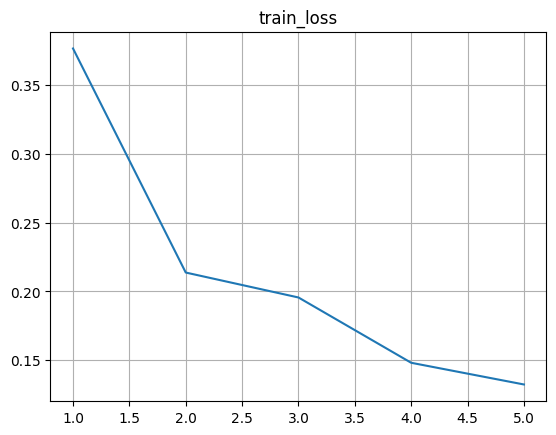

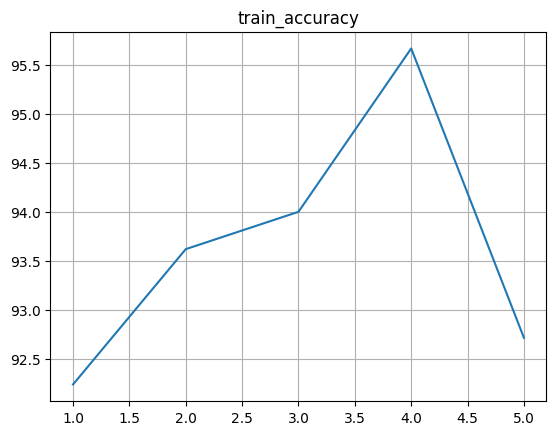

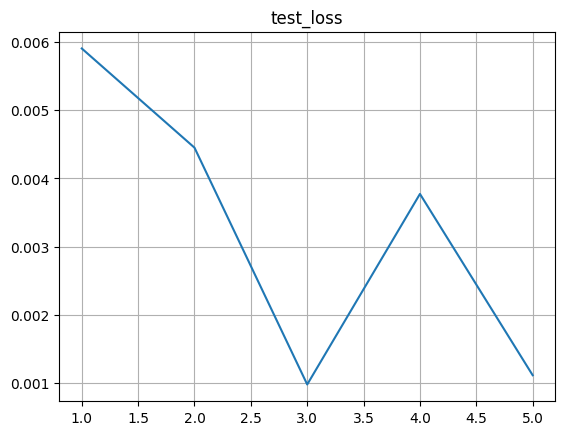

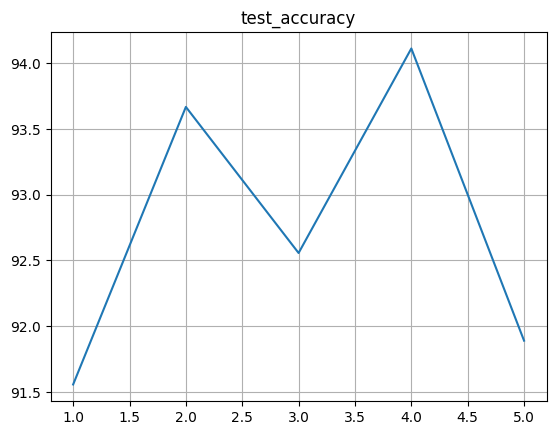

In [23]:
for name, values in zip(
    ['train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'],
    [train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history]
    ):

    plotting(values, name)

ResNet-18 быстро начал показывать хорошие результаты. Значения ошибки и accuracy на валидации словно флуктуируют, а не изменяются

### увеличим **batch size**

In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PATH = "./resnet_18_epoch_10_batch_size_64.pth"

In [ ]:
train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history = train(model, train_loader, val_loader, epochs, criterion, optimizer, device, PATH)

  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 1	TOTAL LOSS 0.33192
TRAINING SET	EPOCH: 1	TOTAL ACCURACY 93.90476%
TEST SET	EPOCH: 1	TOTAL LOSS 0.01449
TEST SET	EPOCH: 1	TOTAL ACCURACY 91.11111%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 2	TOTAL LOSS 0.17701
TRAINING SET	EPOCH: 2	TOTAL ACCURACY 95.19048%
TEST SET	EPOCH: 2	TOTAL LOSS 0.01000
TEST SET	EPOCH: 2	TOTAL ACCURACY 92.11111%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 3	TOTAL LOSS 0.14170
TRAINING SET	EPOCH: 3	TOTAL ACCURACY 96.23810%
TEST SET	EPOCH: 3	TOTAL LOSS 0.01501
TEST SET	EPOCH: 3	TOTAL ACCURACY 93.55556%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 4	TOTAL LOSS 0.08993
TRAINING SET	EPOCH: 4	TOTAL ACCURACY 97.52381%
TEST SET	EPOCH: 4	TOTAL LOSS 0.00537
TEST SET	EPOCH: 4	TOTAL ACCURACY 94.77778%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 5	TOTAL LOSS 0.08501
TRAINING SET	EPOCH: 5	TOTAL ACCURACY 96.80952%
TEST SET	EPOCH: 5	TOTAL LOSS 0.01029
TEST SET	EPOCH: 5	TOTAL ACCURACY 94.11111%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 6	TOTAL LOSS 0.13220
TRAINING SET	EPOCH: 6	TOTAL ACCURACY 96.57143%
TEST SET	EPOCH: 6	TOTAL LOSS 0.01592
TEST SET	EPOCH: 6	TOTAL ACCURACY 93.44444%

FINISHED	ACCURACY DECREASES


In [ ]:
print(f"BEST ACCURACY = {max(test_accuracy_history)}%\nResNet18 with {batch_size = }, {epochs = } and Adam")

BEST ACCURACY = 94.77777777777779%
ResNet18 with batch_size = 64, epochs = 10 and Adam


In [ ]:
PATH = "./resnet_18_epoch_10_batch_size_64.pth"

model = resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [ ]:
y_true = []
y_pred = []


with torch.no_grad():
    for data in tqdm(val_loader):
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

  0%|          | 0/15 [00:00<?, ?it/s]

**f1_score**

In [ ]:
f1_score(y_true, y_pred, average='weighted')

0.9279821365036557

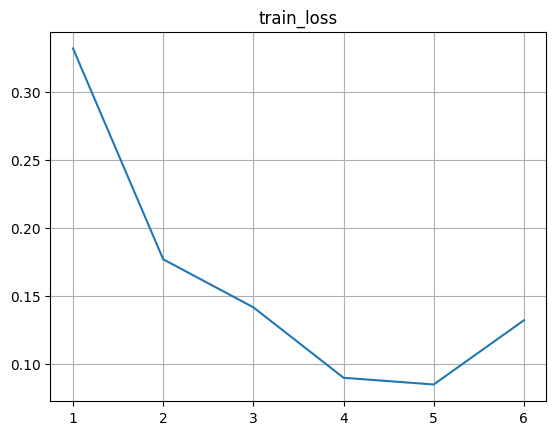

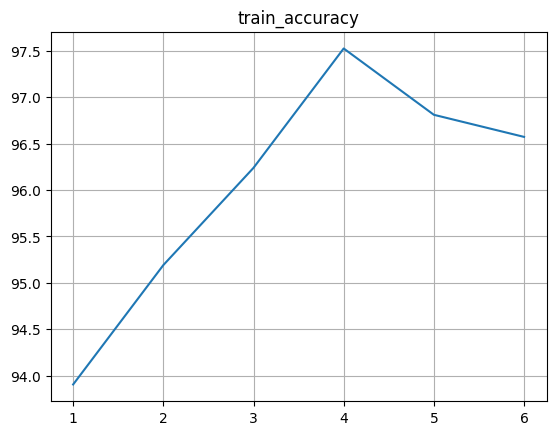

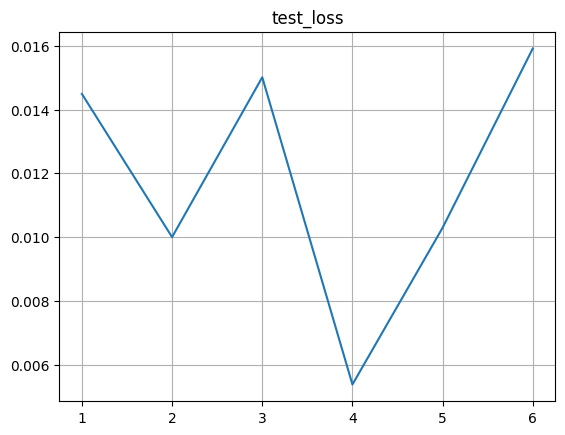

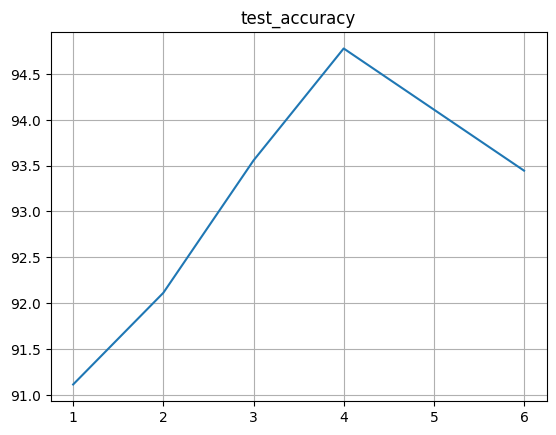

In [ ]:
for name, values in zip(
    ['train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'],
    [train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history]
    ):

    plotting(values, name)

- `accuracy` немного увеличилась
- `f1_score` стал больше

### уменьшим **learning rate**

In [24]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PATH = "./resnet_18_epoch_10_lr_0_0001.pth"

In [25]:
train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history = train(model, train_loader, val_loader, epochs, criterion, optimizer, device, PATH)

  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 1	TOTAL LOSS 0.33670
TRAINING SET	EPOCH: 1	TOTAL ACCURACY 96.00000%
TEST SET	EPOCH: 1	TOTAL LOSS 0.00259
TEST SET	EPOCH: 1	TOTAL ACCURACY 94.33333%



  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 2	TOTAL LOSS 0.08864
TRAINING SET	EPOCH: 2	TOTAL ACCURACY 98.23810%
TEST SET	EPOCH: 2	TOTAL LOSS 0.00273
TEST SET	EPOCH: 2	TOTAL ACCURACY 95.44444%



  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 3	TOTAL LOSS 0.05682
TRAINING SET	EPOCH: 3	TOTAL ACCURACY 98.38095%
TEST SET	EPOCH: 3	TOTAL LOSS 0.00415
TEST SET	EPOCH: 3	TOTAL ACCURACY 93.66667%



  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 4	TOTAL LOSS 0.05684
TRAINING SET	EPOCH: 4	TOTAL ACCURACY 99.04762%
TEST SET	EPOCH: 4	TOTAL LOSS 0.00088
TEST SET	EPOCH: 4	TOTAL ACCURACY 96.22222%



  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 5	TOTAL LOSS 0.04899
TRAINING SET	EPOCH: 5	TOTAL ACCURACY 99.09524%
TEST SET	EPOCH: 5	TOTAL LOSS 0.00222
TEST SET	EPOCH: 5	TOTAL ACCURACY 95.22222%



  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 6	TOTAL LOSS 0.02908
TRAINING SET	EPOCH: 6	TOTAL ACCURACY 99.38095%
TEST SET	EPOCH: 6	TOTAL LOSS 0.00158
TEST SET	EPOCH: 6	TOTAL ACCURACY 96.44444%



  0%|          | 0/66 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 7	TOTAL LOSS 0.02218
TRAINING SET	EPOCH: 7	TOTAL ACCURACY 99.57143%
TEST SET	EPOCH: 7	TOTAL LOSS 0.00113
TEST SET	EPOCH: 7	TOTAL ACCURACY 95.33333%

FINISHED	ACCURACY DECREASES


In [26]:
print(f"BEST ACCURACY = {max(test_accuracy_history)}%\nResNet18 with {batch_size = }, {epochs = } and Adam with lr = 0.0001")

BEST ACCURACY = 96.44444444444444%
ResNet18 with batch_size = 32, epochs = 10 and Adam with lr = 0.0001


In [27]:
PATH = "./resnet_18_epoch_10_lr_0_0001.pth"

model = resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [28]:
y_true = []
y_pred = []


with torch.no_grad():
    for data in tqdm(val_loader):
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

  0%|          | 0/29 [00:00<?, ?it/s]

**f1_score**

In [29]:
f1_score(y_true, y_pred, average='weighted')

0.9480177587087528

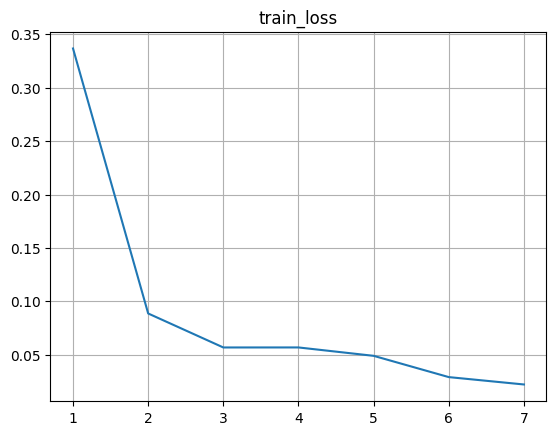

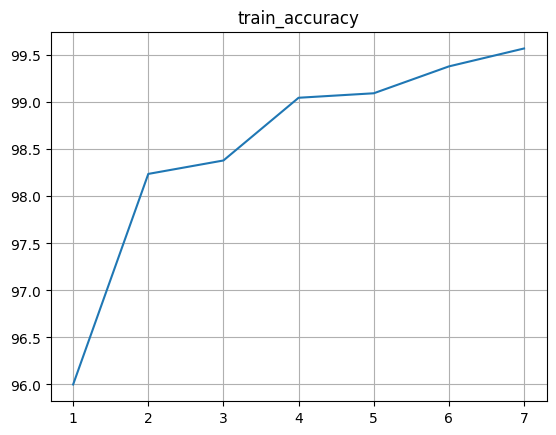

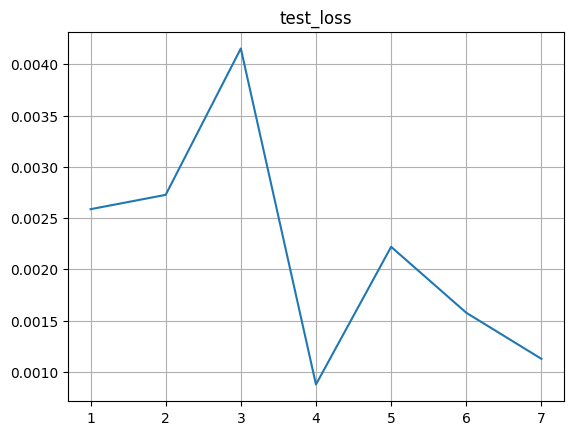

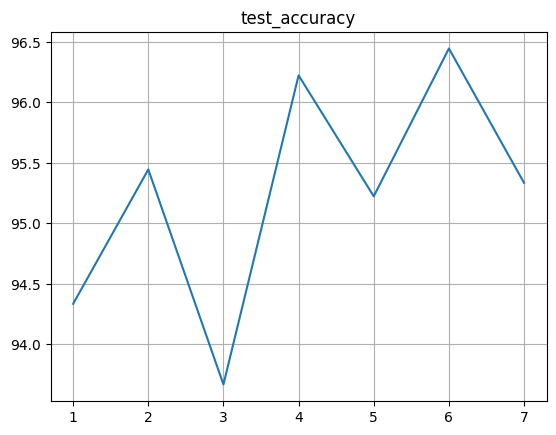

In [30]:
for name, values in zip(
    ['train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'],
    [train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history]
    ):

    plotting(values, name)

- **accuracy** увеличилась
- **f1_score** увеличился

графики обучения кажутся стабильными, на валидации они флуктуируют, но всё равно ошибка уменьшается, а точность увеличивается

### увеличим **batch_size**, уменьшим **learning_rate**

In [31]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PATH = "./resnet_18_epoch_10_batch_size_64_lr_0_0001.pth"

In [32]:
train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history = train(model, train_loader, val_loader, epochs, criterion, optimizer, device, PATH)

  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 1	TOTAL LOSS 0.39824
TRAINING SET	EPOCH: 1	TOTAL ACCURACY 97.14286%
TEST SET	EPOCH: 1	TOTAL LOSS 0.00608
TEST SET	EPOCH: 1	TOTAL ACCURACY 93.33333%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 2	TOTAL LOSS 0.07621
TRAINING SET	EPOCH: 2	TOTAL ACCURACY 99.09524%
TEST SET	EPOCH: 2	TOTAL LOSS 0.00290
TEST SET	EPOCH: 2	TOTAL ACCURACY 94.88889%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 3	TOTAL LOSS 0.04125
TRAINING SET	EPOCH: 3	TOTAL ACCURACY 99.61905%
TEST SET	EPOCH: 3	TOTAL LOSS 0.00284
TEST SET	EPOCH: 3	TOTAL ACCURACY 94.66667%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 4	TOTAL LOSS 0.02640
TRAINING SET	EPOCH: 4	TOTAL ACCURACY 99.57143%
TEST SET	EPOCH: 4	TOTAL LOSS 0.00855
TEST SET	EPOCH: 4	TOTAL ACCURACY 95.22222%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 5	TOTAL LOSS 0.02714
TRAINING SET	EPOCH: 5	TOTAL ACCURACY 99.57143%
TEST SET	EPOCH: 5	TOTAL LOSS 0.00292
TEST SET	EPOCH: 5	TOTAL ACCURACY 95.00000%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 6	TOTAL LOSS 0.02087
TRAINING SET	EPOCH: 6	TOTAL ACCURACY 99.71429%
TEST SET	EPOCH: 6	TOTAL LOSS 0.01015
TEST SET	EPOCH: 6	TOTAL ACCURACY 95.33333%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 7	TOTAL LOSS 0.01923
TRAINING SET	EPOCH: 7	TOTAL ACCURACY 99.66667%
TEST SET	EPOCH: 7	TOTAL LOSS 0.00781
TEST SET	EPOCH: 7	TOTAL ACCURACY 95.22222%



  0%|          | 0/33 [00:00<?, ?it/s]

TRAINING SET	EPOCH: 8	TOTAL LOSS 0.02031
TRAINING SET	EPOCH: 8	TOTAL ACCURACY 99.66667%
TEST SET	EPOCH: 8	TOTAL LOSS 0.00848
TEST SET	EPOCH: 8	TOTAL ACCURACY 94.55556%

FINISHED	ACCURACY DECREASES


In [33]:
print(f"BEST ACCURACY = {max(test_accuracy_history)}%\nResNet18 with {batch_size = }, {epochs = } and Adam with lr = 0.0001")

BEST ACCURACY = 95.33333333333334%
ResNet18 with batch_size = 64, epochs = 10 and Adam with lr = 0.0001


In [34]:
PATH = "./resnet_18_epoch_10_batch_size_64_lr_0_0001.pth"

model = resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [35]:
y_true = []
y_pred = []


with torch.no_grad():
    for data in tqdm(val_loader):
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

  0%|          | 0/15 [00:00<?, ?it/s]

**f1_score**

In [36]:
f1_score(y_true, y_pred, average='weighted')

0.9433259259259259

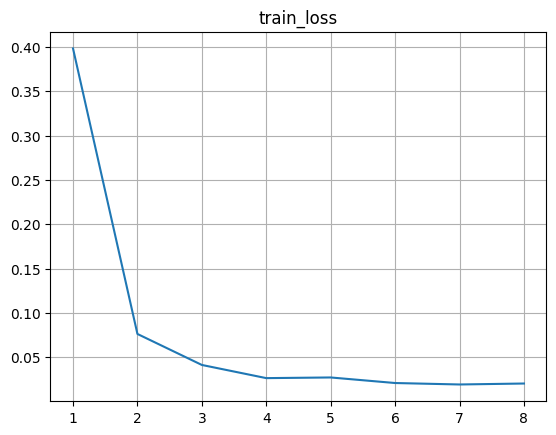

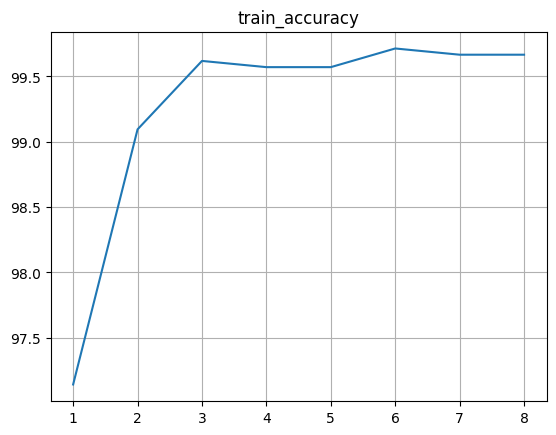

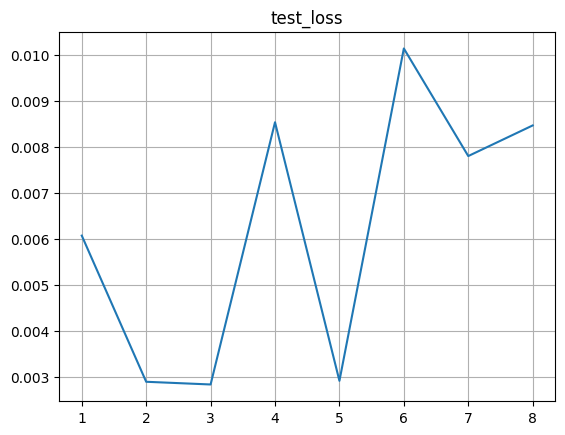

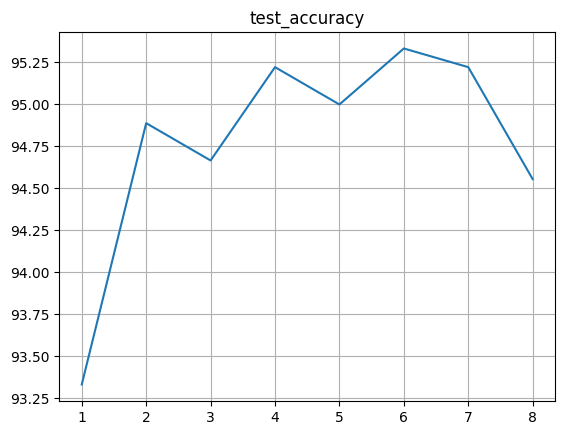

In [37]:
for name, values in zip(
    ['train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'],
    [train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history]
    ):

    plotting(values, name)

- хорошие результаты, но не лучшие
- быстро обучается и быстро переобучается